<a href="https://colab.research.google.com/github/Fbehr-data/Radiant-Earth-Spot-Crop/blob/script_spectral/Random_forest_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baseline model notebook
*by Anitha*

In this notebook I will  create a Random forest model from the baseline model .
The first step is to connect the Google Drive, import the modules and load the data. 

In [ ]:
#Connect the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import the modules, set the working directories and load the data.

In [ ]:
# Import the needed modules
import numpy as np
import pandas as pd
from matplotlib import pyplot
import datetime
!pip install rasterio
import seaborn as sns
from scipy import stats 
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import seaborn as sns
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import hyperopt.pyll.stochastic
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    log_loss, 
    confusion_matrix, 
    classification_report
    )
from IPython.core.pylabtools import figsize
%matplotlib inline
from sklearn.decomposition import PCA

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
 # Set the directory of the data 
OUTPUT_DIR = '/content/drive/MyDrive/Radiant_Earth_Spot_Crop/data'
# Load the base data from the CSV files
df_train = pd.read_csv(f'{OUTPUT_DIR}/Train_Dataset4.csv')
df_test = pd.read_csv(f'{OUTPUT_DIR}/Test_Dataset.csv')

In [ ]:
df_train

,PVR_10,PVR_11,PVR_5,PVR_6,PVR_7,PVR_8,PVR_9,WET_10,WET_11,WET_5,...,B03_9,B08_10,B08_11,B08_5,B08_6,B08_7,B08_8,B08_9,field_id,label
0,0.008887,-0.074323,-0.025132,0.002942,0.037134,0.012042,0.018301,9.530972,4.341476,3.533203,...,33.900660,96.235099,95.397353,83.794700,229.274835,177.644587,196.947020,115.331120,4,8
1,0.016525,-0.002996,-0.032137,-0.007467,0.011969,0.013687,0.030315,42.750818,75.138902,38.502390,...,24.897316,206.057050,211.086915,140.229032,158.967952,156.305369,216.604700,103.868790,8,8
2,-0.057158,0.004799,-0.022349,-0.036778,-0.040924,-0.017682,-0.000231,18.283076,40.125757,-10.935888,...,147.237046,181.208116,199.595850,129.074840,136.039723,159.213295,135.435230,151.792744,20,8
3,0.008609,0.008044,-0.105637,-0.065448,0.031268,0.012414,0.011631,-0.916623,61.607134,-38.461867,...,103.547620,167.833325,218.035715,36.785713,144.678572,139.261900,146.706350,110.404760,25,3
4,-0.075331,0.008205,0.001860,-0.049030,-0.017710,0.003410,-0.008064,-15.489066,61.639118,36.730591,...,144.434690,132.874568,215.809040,154.540947,129.144178,143.842555,178.515575,155.245457,46,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38011,0.001796,-0.100541,-0.036765,0.004932,0.015004,-0.021882,0.036488,13.212385,-48.847171,-7.721359,...,46.716870,148.978915,77.614456,115.536145,112.963850,130.174697,151.192760,106.397590,122660,1
38012,0.013920,-0.028557,0.001684,0.028805,0.055410,0.008256,0.016852,90.443089,16.509583,25.351961,...,172.040020,246.655610,148.447429,139.378095,186.074250,136.414255,240.100590,188.823060,122672,1
38013,0.005288,-0.014724,-0.034381,-0.005345,0.000100,0.002048,0.005152,93.902620,17.662326,-3.344103,...,202.970907,193.596440,176.064835,107.543015,114.641272,120.978678,151.953013,219.036203,122675,1
38014,0.017366,-0.099865,0.008437,-0.012717,-0.011238,0.025922,-0.027129,50.228650,-41.629268,43.892027,...,24.426911,234.340530,84.042637,138.544850,183.176080,102.321152,171.555643,66.745014,122685,1


## Randomforest Model

For our model, we only worked on the mean bands for each field and each month and chose a RandomForest classifier, as this is a commonly used model for raster data. 

We chose the F1 score and Accuracy as metrics, since the main goal is to correctly identify as many plants as possible. Neither FP nor FN are particularly bad or good, hence the harmonic mean F1. In addition, we also have an eye on the cross-entropy, because later we will deal with the probabilities with which a class is assigned to a field. 

Here we don't need to do the train-test-split of the data because we already have two dataset the train dataset and the testdataset .

In [ ]:
# Set a random seed
RSEED = 42
np.random.seed(RSEED)

In [ ]:

# get X for the train and validation data
X_train = df_train.drop(columns=["label", "field_id"])
X_val = df_test.drop(columns=["label", "field_id"])

# get y for the train and validation data
y_train = df_train["label"]
y_train = y_train.astype(int)
y_val = df_test["label"]
y_val = y_val.astype(int)

# set the class labels from 0 to 8 
y_train = y_train-1
y_val = y_val-1

In [ ]:
df_train.shape

(38016, 65)

In [ ]:
df_test.shape

(21310, 65)

In [ ]:
labels = y_train.unique()

Here is the baseline model 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Fitting the RF model
rf = RandomForestClassifier(n_estimators = 200, random_state = RSEED, n_jobs = -1, verbose=1,max_features='auto', max_depth=10, criterion='entropy')
rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.1min finished


RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=200,
                       n_jobs=-1, random_state=42, verbose=1)

In [ ]:
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_val)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


In [ ]:
y_proba_train = rf.predict_proba(X_train)
y_proba_test = rf.predict_proba(X_val)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


And the results of our baseline model. 

In [ ]:

print(f'Accuracy on train data: {accuracy_score(y_train, y_pred_train)}')
print(f'Accuracy on test data: {accuracy_score(y_val, y_pred_test)}')
print('---'*10)
print(f'F1-score on train data: {f1_score(y_train, y_pred_train, average="macro")}')
print(f'F1-score on test data: {f1_score(y_val, y_pred_test, average="macro")}')
print('---'*10)
print(f'Cross-entropy on train data: {log_loss(y_train, y_proba_train, labels=labels)}')
print(f'Cross-entropy on test data: {log_loss(y_val, y_proba_test, labels=labels)}')
print('---'*10)

Accuracy on train data: 0.6712699915824916
Accuracy on test data: 0.5045049272641953
------------------------------
F1-score on train data: 0.6670369482424398
F1-score on test data: 0.35927458148793284
------------------------------
Cross-entropy on train data: 1.2993633296965548
Cross-entropy on test data: 1.3616707572370121
------------------------------


In [ ]:
df_train.columns.shape

(65,)

NDVI_9    0.060823
PVR_8     0.050328
NDVI_8    0.047991
PVR_9     0.040070
PVR_11    0.038398
            ...   
B11_8     0.005966
B11_10    0.005822
B04_10    0.005800
B03_10    0.005717
B02_10    0.005712
Length: 63, dtype: float64

## hyperparameter tuning 
we are going to do the modelling by trying out a wide range of parameters and see what works! the main goal is to fight the overfitting.
We will try adjusting the following set of hyperparameters:
* n_estimators = number of trees in the foreset

* max_features = max number of features considered for splitting a node
* max_depth = max number of levels in each decision tree
* min_samples_split = min number of data points placed in a node before the node is split
* min_samples_leaf = min number of data points allowed in a leaf node


In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Fitting the RF model
rf = RandomForestClassifier(n_estimators = 200, random_state = 42, n_jobs = -1, verbose=1,max_features='auto', max_depth=20, criterion='gini',min_samples_split=80, min_samples_leaf=50)
rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   15.0s finished


RandomForestClassifier(max_depth=20, min_samples_leaf=50, min_samples_split=80,
                       n_estimators=200, n_jobs=-1, random_state=42, verbose=1)

In [ ]:
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_val)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


In [ ]:
y_proba_train = rf.predict_proba(X_train)
y_proba_test = rf.predict_proba(X_val)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


Result of hyperparameter tuning

In [ ]:

print(f'Accuracy on train data: {accuracy_score(y_train, y_pred_train)}')
print(f'Accuracy on test data: {accuracy_score(y_val, y_pred_test)}')
print('---'*10)
print(f'F1-score on train data: {f1_score(y_train, y_pred_train, average="macro")}')
print(f'F1-score on test data: {f1_score(y_val, y_pred_test, average="macro")}')
print('---'*10)
print(f'Cross-entropy on train data: {log_loss(y_train, y_proba_train, labels=labels)}')
print(f'Cross-entropy on test data: {log_loss(y_val, y_proba_test, labels=labels)}')
print('---'*10)

Accuracy on train data: 0.5538983585858586
Accuracy on test data: 0.47672454246832474
------------------------------
F1-score on train data: 0.5406959285357528
F1-score on test data: 0.3384350818818562
------------------------------
Cross-entropy on train data: 1.4586724203091486
Cross-entropy on test data: 1.4170664347259196
------------------------------


## Hyperparameter tuning via Bayesian optimization

1st Round 

In [ ]:
# hp.uniform for float number
# hp.quniform for int that are a multiple from the last number, 
# for example 3, 15, 1 means any whole number between 3 and 15


space={
    'criterion': hp.choice('criterion',('gini', 'entropy')),
    'n_estimators': hp.quniform('n_estimators', 200, 800,100),
    'random_state': RSEED,
    'bootstrap':hp.choice('bootstrap',('True', 'False')),
    'max_features':hp.choice('max_features',('auto', 'sqrt')),
    'min_samples_leaf': hp.quniform('min_samples_leaf',20, 60,10),
    'max_depth': hp.quniform('max_depth', 10, 40,5),
    'min_samples_split':hp.quniform('min_samples_split',20, 80,10),
    }
print(hyperopt.pyll.stochastic.sample(space))

{'bootstrap': 'True', 'criterion': 'entropy', 'max_depth': 35.0, 'max_features': 'auto', 'min_samples_leaf': 40.0, 'min_samples_split': 40.0, 'n_estimators': 700.0, 'random_state': 42}


In [ ]:
def objective(space):
    rfc = RandomForestClassifier(
        criterion =space['criterion'],
        n_estimators=int(space['n_estimators']),
        random_state=space['random_state'],
        bootstrap =space['bootstrap'],
        max_features =space['max_features'],
         min_samples_leaf=int(space['min_samples_leaf']),
        max_depth=int(space['max_depth']),
        min_samples_split=int(space['min_samples_split']) 
        )
    
    evaluation = [
                  ( X_train, y_train), 
                  ( X_val, y_val)
    ]
                
    rfc.fit(
        X_train, y_train
        )
    
    y_pred_val = rfc.predict(X_val)
    f1 = f1_score(y_val, y_pred_val, average="macro")
    print ("SCORE:", f1)
    return {'loss': -f1, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 30,
                        trials = trials)

SCORE:
0.37265443683848254
SCORE:
0.3253407404693183
SCORE:
0.35402651541164154
SCORE:
0.35360320903807146
SCORE:
0.35273556770956876
SCORE:
0.3396041864633153
SCORE:
0.3725194757375259
SCORE:
0.36284435589544056
SCORE:
0.3687237608878585
SCORE:
0.3139896686237828
SCORE:
0.3338474085475112
SCORE:
0.3394928813681316
SCORE:
0.3484612046640352
SCORE:
0.35289643913651353
SCORE:
0.37265443683848254
SCORE:
0.3393193480276922
SCORE:
0.34854377341884657
SCORE:
0.33400026842874614
SCORE:
0.3543236553754764
SCORE:
0.32474184103139236
SCORE:
0.37265443683848254
SCORE:
0.3721580360330483
SCORE:
0.37265443683848254
SCORE:
0.3555328836871643
SCORE:
0.3405849417774403
SCORE:
0.37265443683848254
SCORE:
0.35360320903807146
SCORE:
0.3721580360330483
SCORE:
0.36606454180668774
SCORE:
0.3542045457665173
100%|██████████| 30/30 [2:46:36<00:00, 333.21s/it, best loss: -0.37265443683848254]


In [ ]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'bootstrap': 1, 'criterion': 1, 'max_depth': 35.0, 'max_features': 1, 'min_samples_leaf': 20.0, 'min_samples_split': 30.0, 'n_estimators': 600.0}


In [ ]:
best= RandomForestClassifier(n_estimators=600,
                                                    min_samples_split = 30,
                                                    min_samples_leaf = 20,
                                                    max_features = 1,
                                                    max_depth = 35,
                                                    bootstrap = 1
                                                    )

In [ ]:
best.fit(X_train, y_train)

RandomForestClassifier(bootstrap=1, max_depth=35, max_features=1,
                       min_samples_leaf=20, min_samples_split=30,
                       n_estimators=600)

In [ ]:
y_predu_train = best.predict(X_train)
y_predu_test = best.predict(X_val)
y_probab_train = best.predict_proba(X_train)
y_probab_test = best.predict_proba(X_val)

In [ ]:

print(f'Accuracy on train data: {accuracy_score(y_train, y_predu_train)}')
print(f'Accuracy on test data: {accuracy_score(y_val, y_predu_test)}')
print('---'*10)
print(f'F1-score on train data: {f1_score(y_train, y_predu_train, average="macro")}')
print(f'F1-score on test data: {f1_score(y_val, y_predu_test, average="macro")}')
print('---'*10)
print(f'Cross-entropy on train data: {log_loss(y_train, y_probab_train, labels=labels)}')
print(f'Cross-entropy on test data: {log_loss(y_val, y_probab_test, labels=labels)}')
print('---'*10)

Accuracy on train data: 0.6882891414141414
Accuracy on test data: 0.4917878930079775
------------------------------
F1-score on train data: 0.6836331877709291
F1-score on test data: 0.3545702612910124
------------------------------
Cross-entropy on train data: 1.4310877547307561
Cross-entropy on test data: 1.48234380766628
------------------------------


2nd Round

In [ ]:

space={
    'criterion': hp.choice('criterion',('gini', 'entropy')),
    'n_estimators': hp.quniform('n_estimators', 200,2000,200),
    'random_state': RSEED,
    'bootstrap':hp.choice('bootstrap',('True', 'False')),
    'max_features':hp.choice('max_features',('auto', 'sqrt')),
    'min_samples_leaf': hp.quniform('min_samples_leaf',4,6,2),
    'max_depth': hp.quniform('max_depth', 10, 110,11),
    'min_samples_split':hp.quniform('min_samples_split',10,25,5),
    }
print(hyperopt.pyll.stochastic.sample(space))

{'bootstrap': 'True', 'criterion': 'entropy', 'max_depth': 110.0, 'max_features': 'sqrt', 'min_samples_leaf': 4.0, 'min_samples_split': 25.0, 'n_estimators': 400.0, 'random_state': 42}


In [ ]:
def objective(space):
    rfc = RandomForestClassifier(
        criterion =space['criterion'],
        n_estimators=int(space['n_estimators']),
        random_state=space['random_state'],
        bootstrap =space['bootstrap'],
        max_features =space['max_features'],
         min_samples_leaf=int(space['min_samples_leaf']),
        max_depth=int(space['max_depth']),
        min_samples_split=int(space['min_samples_split']) 
        )
    
    evaluation = [
                  ( X_train, y_train), 
                  ( X_val, y_val)
    ]
                
    rfc.fit(
        X_train, y_train
        )
    
    y_pred_val = rfc.predict(X_val)
    f1 = f1_score(y_val, y_pred_val, average="macro")
    print ("SCORE:", f1)
    return {'loss': -f1, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 30,
                        trials = trials)

SCORE:
0.4275209686489616
SCORE:
0.4104194601738944
SCORE:
0.426268859953671
SCORE:
0.41943001770830446
SCORE:
0.4067888069157578
SCORE:
0.42741002384733556
SCORE:
0.40288949505165167
SCORE:
0.42524987347648097
SCORE:
0.4351450151673339
SCORE:
0.41327201238580713
SCORE:
0.4244361656637772
SCORE:
0.41233734492473645
SCORE:
0.41296514839073784
SCORE:
0.41156977719352206
SCORE:
0.4261694857143402
SCORE:
0.4181700207391175
SCORE:
0.4082755441141816
SCORE:
0.426268859953671
SCORE:
0.4189605467272247
SCORE:
0.4352576284890531
SCORE:
0.37122366129309037
SCORE:
0.3712643724928292
SCORE:
0.4340504743523874
SCORE:
0.435797712692577
SCORE:
0.4363314925164333
SCORE:
0.4363314925164333
SCORE:
0.4363314925164333
SCORE:
0.4363314925164333
SCORE:
0.43668492006600396
SCORE:
0.43668492006600396
100%|██████████| 30/30 [5:45:28<00:00, 690.96s/it, best loss: -0.43668492006600396]


In [ ]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'bootstrap': 0, 'criterion': 0, 'max_depth': 88.0, 'max_features': 1, 'min_samples_leaf': 4.0, 'min_samples_split': 10.0, 'n_estimators': 2000.0}


In [ ]:
best= RandomForestClassifier(n_estimators=2000,
                                                    min_samples_split = 10,
                                                    min_samples_leaf = 4,
                                                    max_features = 1,
                                                    max_depth = 88,
                                                    bootstrap = 0)

In [ ]:
best.fit(X_train, y_train)

RandomForestClassifier(bootstrap=0, max_depth=88, max_features=1,
                       min_samples_leaf=4, min_samples_split=10,
                       n_estimators=2000)

In [ ]:
y_predu_train = best.predict(X_train)
y_predu_test = best.predict(X_val)
y_probab_train = best.predict_proba(X_train)
y_probab_test = best.predict_proba(X_val)

In [ ]:

print(f'Accuracy on train data: {accuracy_score(y_train, y_predu_train)}')
print(f'Accuracy on test data: {accuracy_score(y_val, y_predu_test)}')
print('---'*10)
print(f'F1-score on train data: {f1_score(y_train, y_predu_train, average="macro")}')
print(f'F1-score on test data: {f1_score(y_val, y_predu_test, average="macro")}')
print('---'*10)
print(f'Cross-entropy on train data: {log_loss(y_train, y_probab_train, labels=labels)}')
print(f'Cross-entropy on test data: {log_loss(y_val, y_probab_test, labels=labels)}')
print('---'*10)

Accuracy on train data: 0.9930292508417509
Accuracy on test data: 0.5709056780854059
------------------------------
F1-score on train data: 0.9930380095369691
F1-score on test data: 0.43595085330059785
------------------------------
Cross-entropy on train data: 0.6793454111532213
Cross-entropy on test data: 1.2866951265147946
------------------------------


## Random Hyperparameter Grid
To use RandomizedSearchCV, we first need to create a parameter grid to sample from during fitting:


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 300, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [10, 42, 74, 106, 138, 171, 203, 235, 267, 300]}


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

Now, we instantiate the random search and fit it

In [ ]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
rf = RandomForestClassifier(n_estimators = 200, random_state = RSEED, n_jobs = -1, verbose=1,max_features='auto', max_depth=10, criterion='entropy')
# Use the random grid to search for best hyperparameters
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=10, cv=3, verbose=2)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 235 out of 235 | elapsed:  1.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 235 out of 235 | elapsed:    0.3s finished


[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=235; total time= 1.7min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 235 out of 235 | elapsed:  1.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 235 out of 235 | elapsed:    0.3s finished


[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=235; total time= 1.7min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 235 out of 235 | elapsed:  1.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 235 out of 235 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=235; total time= 1.8min


[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:   11.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 out of  42 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=42; total time=  11.4s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:   11.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 out of  42 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=42; total time=  11.4s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:   11.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 out of  42 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=42; total time=  11.8s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 106 out of 106 | elapsed:   45.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 106 out of 106 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=106; total time=  45.7s


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 106 out of 106 | elapsed:   45.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 106 out of 106 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=106; total time=  45.7s


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 106 out of 106 | elapsed:   47.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 106 out of 106 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=106; total time=  48.2s


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 171 out of 171 | elapsed:   46.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 171 out of 171 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=171; total time=  47.3s


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 171 out of 171 | elapsed:   47.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 171 out of 171 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=171; total time=  47.4s


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 171 out of 171 | elapsed:   48.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 171 out of 171 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=171; total time=  49.1s


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 267 out of 267 | elapsed:  1.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 267 out of 267 | elapsed:    0.4s finished


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=267; total time= 1.2min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done 267 out of 267 | elapsed:  1.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 267 out of 267 | elapsed:    0.4s finished


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=267; total time= 1.2min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   52.6s
[Parallel(n_jobs=-1)]: Done 267 out of 267 | elapsed:  1.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 267 out of 267 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=267; total time= 1.2min


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:   34.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  74 out of  74 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=74; total time=  34.3s


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:   34.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  74 out of  74 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=74; total time=  34.4s


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:   36.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  74 out of  74 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=74; total time=  36.4s


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 267 out of 267 | elapsed:  2.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 267 out of 267 | elapsed:    0.4s finished


[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=267; total time= 2.0min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 267 out of 267 | elapsed:  2.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 267 out of 267 | elapsed:    0.4s finished


[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=267; total time= 2.0min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 267 out of 267 | elapsed:  2.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 267 out of 267 | elapsed:    0.4s finished


[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=267; total time= 2.2min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:   33.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  74 out of  74 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=74; total time=  34.2s


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:   34.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  74 out of  74 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=74; total time=  34.4s


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:   35.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  74 out of  74 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=74; total time=  36.2s


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   3.2s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   3.2s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   3.3s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:   18.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 out of  42 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=42; total time=  18.3s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:   18.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 out of  42 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=42; total time=  18.4s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:   19.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 out of  42 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=42; total time=  19.3s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 267 out of 267 | elapsed:  3.2min finished


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(criterion='entropy',
                                                    max_depth=10,
                                                    n_estimators=200, n_jobs=-1,
                                                    random_state=42,
                                                    verbose=1),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 42, 74, 106, 138,
                                          

We can view the best parameters from fitting the random search ,from these results we will do our best model

In [ ]:
best_random = rf_random.best_params_
best_random

{'bootstrap': False,
 'max_depth': 40,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 267}

In [ ]:
best= RandomForestClassifier(n_estimators=267,
                                                    min_samples_split = 2,
                                                    min_samples_leaf = 1,
                                                    max_features = 'auto',
                                                    max_depth = 40,
                                                    bootstrap = False)

In [ ]:
best.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=40, n_estimators=267)

In [ ]:
y_predi_train = best.predict(X_train)
y_predi_test = best.predict(X_val)

In [ ]:
y_proba_train = best.predict_proba(X_train)
y_proba_test = best.predict_proba(X_val)

Here is the Result using RandomizedsearchCV , comparing with the result of the baseline model ,we can see that the scores increased but still overfitting 

In [ ]:

print(f'Accuracy on train data: {accuracy_score(y_train, y_predi_train)}')
print(f'Accuracy on test data: {accuracy_score(y_val, y_predi_test)}')
print('---'*10)
print(f'F1-score on train data: {f1_score(y_train, y_predi_train, average="macro")}')
print(f'F1-score on test data: {f1_score(y_val, y_predi_test, average="macro")}')
print('---'*10)
print(f'Cross-entropy on train data: {log_loss(y_train, y_proba_train, labels=labels)}')
print(f'Cross-entropy on test data: {log_loss(y_val, y_proba_test, labels=labels)}')
print('---'*10)

Accuracy on train data: 1.0
Accuracy on test data: 0.6100422336931018
------------------------------
F1-score on train data: 1.0
F1-score on test data: 0.47644495715286994
------------------------------
Cross-entropy on train data: 1.1209557333598322e-05
Cross-entropy on test data: 1.0816152230082536
------------------------------


## Error Analysis 


###Feature Importance 
We want to take a look in the features we have and see which one are really important ,To get the feature importances from the Random Forest model use the feature_importances_ attribute

In [ ]:
# feature importance of the baseline model
feature_imp = pd.Series(rf.feature_importances_,X_train.columns).sort_values(ascending=False)
feature_imp

NDVI_9    0.060823
PVR_8     0.050328
NDVI_8    0.047991
PVR_9     0.040070
PVR_11    0.038398
            ...   
B11_8     0.005966
B11_10    0.005822
B04_10    0.005800
B03_10    0.005717
B02_10    0.005712
Length: 63, dtype: float64

Let’s plot the importances (chart will be easier to interpret than values)

No handles with labels found to put in legend.


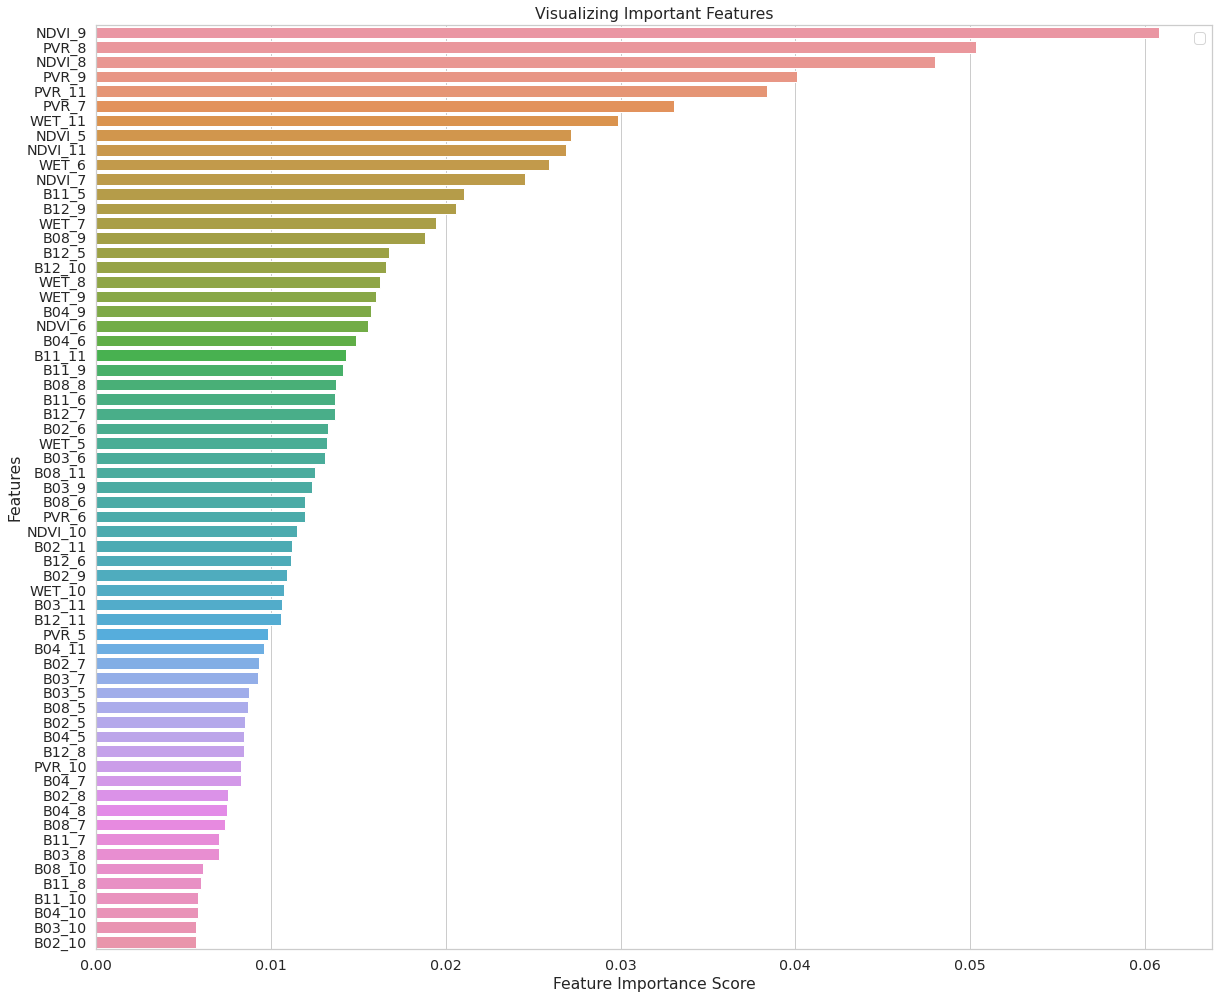

In [ ]:

# Creating a bar plot
cmap =sns.color_palette('crest')
plt.figure(figsize = (20, 17))
sns.set(style="whitegrid", font_scale = 1.3)
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

We observe that, the six index features are found most important

### Confusion matrix

In [ ]:
# View confusion matrix for test data and predictions
confusion_matrix(y_val, y_predi_test)

array([[1037,  179,   63,   94,   53,  158,  365,   41,    0],
       [ 245, 1860,  110,  287,  192,  326,  193,   86,    0],
       [  60,  112,  927,  186,  225,   88,   63,  147,    0],
       [ 104,  498,  113, 5183,  120,   70,   56,   24,    0],
       [  30,   96,  198,  124, 1054,   55,   29,  152,    0],
       [ 168,  186,   91,   32,  121,  948,  408,   65,    0],
       [ 238,  111,   50,   24,   48,  317, 1894,   52,    0],
       [  38,   28,    2,    3,    3,   55,  149,   97,    0],
       [  11,   22,   80,    8,  112,   32,   20,  894,    0]])

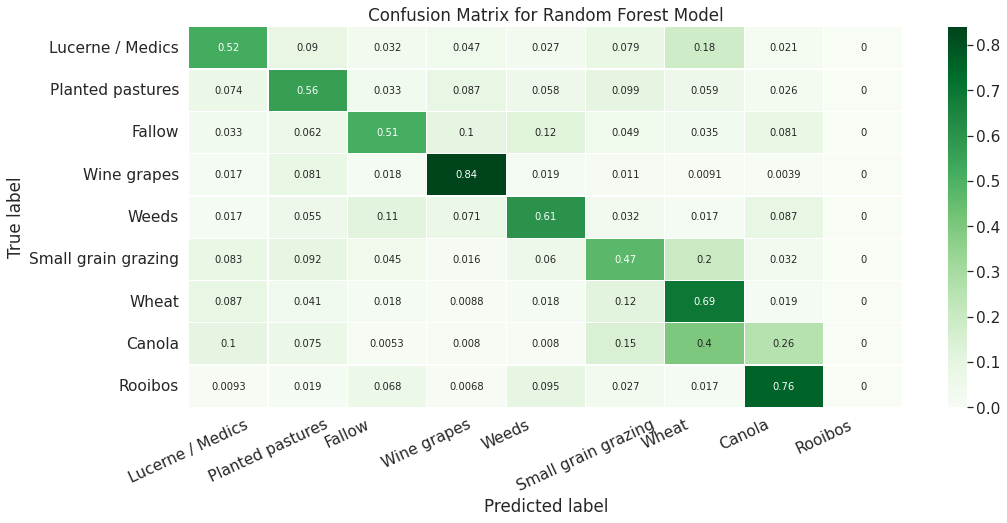

In [ ]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_val, y_predi_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Lucerne / Medics', 'Planted pastures', 'Fallow', 
               'Wine grapes', 'Weeds', 'Small grain grazing',    
               'Wheat','Canola','Rooibos']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

## Principal Components Analysis(PCA)
Using dimension reduction, we can approximate the original dataset with fewer variables, while reducing computational power to run our model. Using PCA.

In [ ]:
X_train.shape

(38016, 63)

In [ ]:
X_train.columns

Index(['PVR_10', 'PVR_11', 'PVR_5', 'PVR_6', 'PVR_7', 'PVR_8', 'PVR_9',
       'WET_10', 'WET_11', 'WET_5', 'WET_6', 'WET_7', 'WET_8', 'WET_9',
       'NDVI_10', 'NDVI_11', 'NDVI_5', 'NDVI_6', 'NDVI_7', 'NDVI_8', 'NDVI_9',
       'B12_10', 'B12_11', 'B12_5', 'B12_6', 'B12_7', 'B12_8', 'B12_9',
       'B11_10', 'B11_11', 'B11_5', 'B11_6', 'B11_7', 'B11_8', 'B11_9',
       'B02_10', 'B02_11', 'B02_5', 'B02_6', 'B02_7', 'B02_8', 'B02_9',
       'B04_10', 'B04_11', 'B04_5', 'B04_6', 'B04_7', 'B04_8', 'B04_9',
       'B03_10', 'B03_11', 'B03_5', 'B03_6', 'B03_7', 'B03_8', 'B03_9',
       'B08_10', 'B08_11', 'B08_5', 'B08_6', 'B08_7', 'B08_8', 'B08_9'],
      dtype='object')

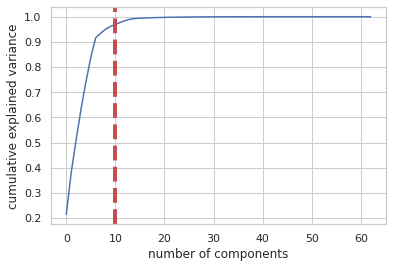

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.214377,0.214377
1,0.380162,0.165785
2,0.510257,0.130095
3,0.632776,0.122519
4,0.741409,0.108633
5,0.838945,0.097537
6,0.916885,0.077940
7,0.934209,0.017325
8,0.950590,0.016380
9,0.961195,0.010605


In [ ]:

pca_test = PCA(n_components=63)
pca_test.fit(X_train)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=10, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(10))

20 Principal Components explain the most variance.on plot we can see that after 20 components there is no variance.So by using PCA, the dimensions are reduces from 63 to 10

In [ ]:
pca = PCA(n_components=10)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_val_pca = pca.transform(X_val)

Each component is a linear combination of the original variables with corresponding “weights”. We can see these “weights” for each PCA component by creating a dataframe.

In [ ]:
pca_dims = []
for x in range(0, len(pca_df)):
    pca_dims.append('PCA Component {}'.format(x))
pca_test_df = pd.DataFrame(pca_test.components_, columns=X_train.columns, index=pca_dims)
pca_test_df.head(10).T

,PCA Component 0,PCA Component 1,PCA Component 2,PCA Component 3,PCA Component 4,PCA Component 5,PCA Component 6,PCA Component 7,PCA Component 8,PCA Component 9
PVR_10,-0.000093,0.000033,0.000014,-0.000027,-0.000056,0.000029,0.000035,-0.000256,-0.000104,-0.000015
PVR_11,0.000034,-0.000066,0.000057,0.000035,-0.000172,0.000023,0.000034,-0.000129,-0.000031,-0.000008
PVR_5,0.000023,0.000105,0.000255,0.000009,0.000067,0.000068,0.000067,-0.000164,-0.000055,0.000238
PVR_6,-0.000071,-0.000102,0.000031,0.000049,0.000008,-0.000043,-0.000019,-0.000096,-0.000227,-0.000015
PVR_7,-0.000099,-0.000077,0.000052,-0.000041,-0.000019,0.000042,0.000161,-0.000166,-0.000160,0.000061
...,...,...,...,...,...,...,...,...,...,...
B08_5,0.025534,0.110473,0.348293,0.092367,0.077253,0.077210,0.077841,0.045619,0.041261,-0.096718
B08_6,-0.183473,-0.209014,0.110345,0.159740,0.042133,-0.200393,-0.110922,-0.063190,0.156310,-0.003310
B08_7,-0.145698,-0.100528,-0.020586,-0.002413,-0.048941,0.046699,0.330561,0.099344,0.039333,0.006819
B08_8,-0.065995,-0.050496,-0.093451,0.179870,0.078587,0.285681,-0.061382,-0.043454,-0.058382,0.016838


Now, we can fit our X_train_scaled_pca and y_train data to the Random Forest model, to see if we get any improvement on the model’s predictions.

In [ ]:
rfc = RandomForestClassifier(n_estimators=42,
                                                    min_samples_split = 2,
                                                    min_samples_leaf = 2,
                                                    max_features = 'auto',
                                                    max_depth = 30,
                                                    bootstrap = False)
rfc.fit(X_train_pca, y_train)
#display(rfc.score(X_train_pca, y_train))

RandomForestClassifier(bootstrap=False, max_depth=30, min_samples_leaf=2,
                       n_estimators=42)

In [ ]:
y_predi_train = rfc.predict(X_train_pca)
y_predi_test = rfc.predict(X_val_pca)

In [ ]:
y_proba_train = rfc.predict_proba(X_train_pca)
y_proba_test = rfc.predict_proba(X_val_pca)

From this result we can see no much improvement to avoid the overfitting

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, log_loss

print(f'Accuracy on train data: {accuracy_score(y_train, y_predi_train)}')
print(f'Accuracy on test data: {accuracy_score(y_val, y_predi_test)}')
print('---'*10)
print(f'F1-score on train data: {f1_score(y_train, y_predi_train, average="macro")}')
print(f'F1-score on test data: {f1_score(y_val, y_predi_test, average="macro")}')
print('---'*10)
print(f'Cross-entropy on train data: {log_loss(y_train, y_proba_train, labels=labels)}')
print(f'Cross-entropy on test data: {log_loss(y_val, y_proba_test, labels=labels)}')
print('---'*10)

Accuracy on train data: 1.0
Accuracy on test data: 0.4702956358517128
------------------------------
F1-score on train data: 1.0
F1-score on test data: 0.3600215747690842
------------------------------
Cross-entropy on train data: 0.2150972694694973
Cross-entropy on test data: 1.4722697819568982
------------------------------
